In [3]:
import pandas as pd
df = pd.read_csv('data_2008_2019.csv')
df.head()

,Date Made Public,Company,City,State,Type of breach,Type of organization,Total Records,Description of incident,Information Source,Source URL,Year of Breach,Latitude,Longitude,Length
0,"July 21, 2008",Hawaii State Department of Public Safety,Honolulu,Hawaii,DISC,GOV,"4,200",A reporter requested statistics from the State...,Databreaches.net,NaN,2011,21.306944,-157.858333,416
1,"June 26, 2009",Massachusetts Technology Collaborative,Boston,Massachusetts,DISC,GOV,810,Residents who applied for the Massachusetts Co...,Dataloss DB,NaN,2011,42.358431,-71.059773,252
2,"January 1, 2010",Netflix,Los Gatos,California,UNKN,BSO,"100,000,000","A class action suit was filed against Netflix,...",Media,NaN,2010,37.226611,-121.974680,1027
3,"January 1, 2010","Washington Department of Corrections, Larch Co...",Tumwater,Washington,PHYS,GOV,43,A briefcase full of sensitive personnel record...,Dataloss DB,NaN,2010,47.007319,-122.909306,832
4,"January 1, 2010",collective2.com,Tenafly,New Jersey,HACK,BSO,"25,000",Users of the do-it-yourself trading site colle...,Media,NaN,2010,40.925377,-73.962915,380


In [4]:
df = df[pd.notnull(df['Description of incident'])]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5459 entries, 0 to 5458
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Date Made Public         5459 non-null   object 
 1   Company                  5459 non-null   object 
 2   City                     4010 non-null   object 
 3   State                    5163 non-null   object 
 4   Type of breach           5459 non-null   object 
 5   Type of organization     5459 non-null   object 
 6   Total Records            5458 non-null   object 
 7   Description of incident  5459 non-null   object 
 8   Information Source       5423 non-null   object 
 9   Source URL               1730 non-null   object 
 10  Year of Breach           5459 non-null   int64  
 11  Latitude                 5459 non-null   float64
 12  Longitude                5459 non-null   float64
 13  Length                   5459 non-null   int64  
dtypes: float64(2), int64(2),

In [6]:
col = ['Type of breach', 'Description of incident']
df = df[col]

In [7]:
df.columns

Index(['Type of breach', 'Description of incident'], dtype='object')

In [8]:
df.columns =['Type_of_breach', 'Description_of_incident']

In [9]:
df['category_id'] = df.Type_of_breach.factorize()[0]
from io import StringIO
category_id_df = df[['Type_of_breach', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Type_of_breach']].values)

In [10]:
df.head()

,Type_of_breach,Description_of_incident,category_id
0,DISC,A reporter requested statistics from the State...,0
1,DISC,Residents who applied for the Massachusetts Co...,0
2,UNKN,"A class action suit was filed against Netflix,...",1
3,PHYS,A briefcase full of sensitive personnel record...,2
4,HACK,Users of the do-it-yourself trading site colle...,3


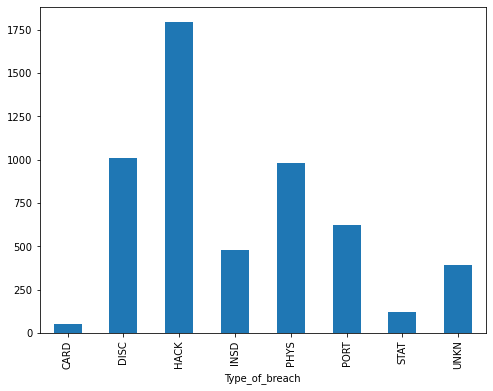

In [11]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Type_of_breach').Description_of_incident.count().plot.bar(ylim=0)
plt.show()

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.Description_of_incident).toarray()
labels = df.category_id
features.shape

(5459, 10139)

In [13]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for Type_of_breach, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Type_of_breach))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# 'CARD':
  . Most correlated unigrams:
       . gas
       . skimming
  . Most correlated bigrams:
       . skimming device
       . skimming devices
# 'DISC':
  . Most correlated unigrams:
       . accidentally
       . error
  . Most correlated bigrams:
       . access disclosure
       . services unauthorized
# 'HACK':
  . Most correlated unigrams:
       . hacker
       . hackers
  . Most correlated bigrams:
       . hacker hackers
       . payment card
# 'INSD':
  . Most correlated unigrams:
       . fired
       . dishonest
  . Most correlated bigrams:
       . employee fired
       . dishonest employee
# 'PHYS':
  . Most correlated unigrams:
       . ephi
       . ce
  . Most correlated bigrams:
       . covered entity
       . laptop business
# 'PORT':
  . Most correlated unigrams:
       . stolen
       . laptop
  . Most correlated bigrams:
       . laptop resulted
       . theft laptop
# 'STAT':
  . Most correlated unigrams:
       . computer
       . computers
  . Most corr

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['Description_of_incident'], df['Type_of_breach'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [15]:
print(clf.predict(count_vect.transform(["The bank account information of 2,499 customers was incorrectly mailed."])))

['DISC']


In [16]:
print(clf.predict(count_vect.transform(["Hackers breached the security of a computer server containing the names, phone numbers and employee ID numbers of current and former Eugene School District employees. The server in question did not contain other personal information but was attached to servers that contain Social Security numbers and other sensitive data. It is possible that the individuals responsible may have accessed names, addresses, dates of birth, Social Security numbers, tax identification numbers and direct-deposit bank account information for current and former staff members."])))

['HACK']


In [17]:
df[df['Description_of_incident'] == "Department store chain Sears Holding Corp (SHLD.O) and Delta Air Lines Inc (DAL.N) said on Wednesday some of their customer payment information may have been exposed in a cyber security breach at software service provider [ 24]7.ai.Department store chain Sears Holding Corp (SHLD.O) and Delta Air Lines Inc (DAL.N) said on Wednesday some of their customer payment information may have been exposed in a cyber security breach at software service provider [ 24]7.ai.A Delta Air Lines flight is pushed put of its gate at the airport in Salt Lake City, Utah, U.S., January 12, 2018. REUTERS/Mike BlakeSears said it was notified of the incident in mid-March and the incident led to unauthorized access to the credit card information of under 100,000 of its customers.Technology firm [ 24]7.ai, which provides online support services for Delta, Sears and Kmart among other companies, found that a cyber security incident affected online customer payment information of its clients, it said.The incident happened on or after Sept. 26, 2017 last year and was found and resolved on Oct. 12, the company said."]

,Type_of_breach,Description_of_incident,category_id
5161,HACK,Department store chain Sears Holding Corp (SHL...,3


In [18]:
df[df['Description_of_incident'] == "In Dec. 2017 EASTCONN suffered a data breach affecting 194 records, incl. Driver's license and SSN."]

,Type_of_breach,Description_of_incident,category_id
5070,INSD,In Dec. 2017 EASTCONN suffered a data breach a...,5


In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(n_jobs=1, C=1e5, max_iter=10000),
]
entries = []
targets = df['Type_of_breach'].unique()
for model in models:
  model_name = model.__class__.__name__
  model.fit(X_train_tfidf, y_train)
  y_predict=model.predict(count_vect.transform(X_test))
  accuracy = accuracy_score(y_predict, y_test)
  entries.append((model_name, accuracy))
train_test_split_df = pd.DataFrame(entries, columns=['model_name', 'accuracy'])
train_test_split_df.groupby('model_name').accuracy

In [45]:
print(train_test_split_df.groupby('model_name').head())

               model_name  accuracy
0  RandomForestClassifier  0.456410
1               LinearSVC  0.782418
2           MultinomialNB  0.531868
3      LogisticRegression  0.676190


In [25]:
from sklearn.model_selection import cross_val_score

CV = 10
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

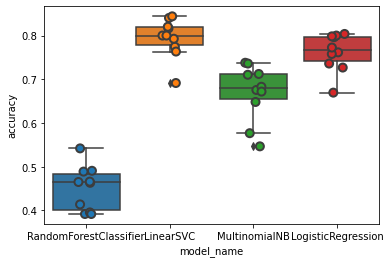

In [27]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [28]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.794632
LogisticRegression        0.762577
MultinomialNB             0.670064
RandomForestClassifier    0.451001
Name: accuracy, dtype: float64

In [32]:
from sklearn.model_selection import train_test_split

model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

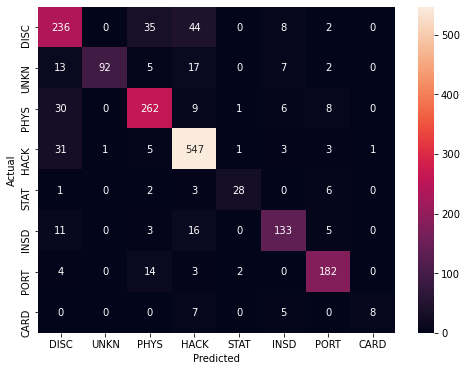

In [35]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Type_of_breach.values, yticklabels=category_id_df.Type_of_breach.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [37]:
from IPython.display import display

for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 6:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Type_of_breach', 'Description_of_incident']])
      print('')

'UNKN' predicted as 'DISC' : 13 examples.


,Type_of_breach,Description_of_incident
977,UNKN,"On February 16, 2011, an IT incident caused pa..."
3537,UNKN,An employee of the covered entity’s (CE) healt...
2355,UNKN,An email containing electronic protected healt...
2038,UNKN,"The covered entity (CE), L.A. Care Health Plan..."
2635,UNKN,"An October 1, 2011 breach resulted in the expo..."
2915,UNKN,"The covered entity (CE), Cook County Health an..."
2443,UNKN,Patients who visited Sutter Health's Alta Bate...
3135,UNKN,"The covered entity (CE), City of Henderson, di..."
282,UNKN,Paper correspondence to certain members in Uni...
938,UNKN,"On February 18 of 2011, it was discovered that..."



'PHYS' predicted as 'DISC' : 30 examples.


,Type_of_breach,Description_of_incident
2932,PHYS,"Triple-S Management Corporation (“TRIPLE-S”), ..."
2842,PHYS,The Covered Entity's (CE) Business Associate (...
1013,PHYS,Veterans and staff had their personal informat...
4129,PHYS,"Grx Holdings, LLC dba Medicap Pharmacy notifie..."
1248,PHYS,An abandoned Indalex plant still contained per...
4666,PHYS,An individual broke into a CVS Pharmacy in Whi...
4646,PHYS,"On May 19, 2016 the business associate (BA), A..."
2974,PHYS,The covered entity (CE) mistakenly mailed prot...
195,PHYS,Up to 800 police files were left in an area wh...
2663,PHYS,"TSYS Employee Health Plan, the covered entity ..."



'HACK' predicted as 'DISC' : 31 examples.


,Type_of_breach,Description_of_incident
1960,HACK,A staff member found that a cable line hooked ...
3685,HACK,"Employees of the covered entity (CE), Children..."
3903,HACK,The Kardashian brand recently launched a new w...
2026,HACK,Two former employees of the covered entity (CE...
4800,HACK,"""For the second time in the past nine months, ..."
1493,HACK,Shareholder 1099 forms were sent to the wrong ...
4980,HACK,"""A bug on T-Mobile‘s website may have allowed ..."
1114,HACK,A computer server belonging to a former busine...
3725,HACK,"Sacred Heart Health System, Inc.’s business as..."
666,HACK,Some records of people affiliated with UW Madi...



'INSD' predicted as 'DISC' : 11 examples.


,Type_of_breach,Description_of_incident
613,INSD,An employee sent an email with the names and S...
896,INSD,Former employees of GunnAllen Financial have b...
2928,INSD,"patient names, addresses, ssn, dob, and certai..."
2961,INSD,Nielsen company announced that an undisclosed ...
2865,INSD,A former doctor took patient information after...
4937,INSD,"""Anthem BlueCross BlueShield began notifying c..."
4971,INSD,"""The confidentiality of more than 26,000 Medic..."
371,INSD,A leak that allowed anti-immigration activists...
4935,INSD,"""A data breach may have exposed personal healt..."
263,INSD,A former stock broker left the firm with the p...



'DISC' predicted as 'PHYS' : 35 examples.


,Type_of_breach,Description_of_incident
4578,DISC,"On August 5, 2016, intruders broke into the co..."
2760,DISC,"On October 14, 2013, the covered entity (CE), ..."
3718,DISC,"A self-storage facility in Hollis, New York au..."
3512,DISC,"name, ssn\nLocation of breached information: P..."
3753,DISC,"On April 9, 2015, OCR received a breach report..."
4162,DISC,"On February 15, 2016, the covered entity (CE),..."
3312,DISC,"On April 15, 2014, the covered entity (CE), Pu..."
3957,DISC,"A workforce member took 4,300 patients’ protec..."
4291,DISC,"On March 2, 2016, a break-in occurred at the o..."
140,DISC,Sensitive city documents were found near a gar...



'PORT' predicted as 'PHYS' : 14 examples.


,Type_of_breach,Description_of_incident
2284,PORT,Two backup tapes with customer and customer de...
3689,PORT,"""One unencrypted laptop computer was stolen du..."
30,PORT,A man broke into a Goodwill store and stole a ...
728,PORT,A steel cabinet was discovered missing on Nove...
4657,PORT,"""On November 4, 2016, I discovered that my hom..."
1972,PORT,An electronic filing report was found during a...
1620,PORT,"On March 12, 2012, the Department of Child Sup..."
3677,PORT,Liberty Tax Services contacted customers to in...
22,PORT,The theft of 57 hard drives from a BlueCross B...
230,PORT,Health records belonging to patients were stol...



'DISC' predicted as 'HACK' : 44 examples.


,Type_of_breach,Description_of_incident
2477,DISC,A code change in the prepaid cardholder websit...
584,DISC,It appears that anyone with a Tech computer ac...
3431,DISC,"name, address, Social Security number, and con..."
3719,DISC,No specifc information was provided by Health ...
3141,DISC,improper disclosure by employee\nLocation of b...
3434,DISC,"names, address, dob, ssn\nLocation of breached..."
2720,DISC,The US Federal Trade Commission filed a compla...
304,DISC,Although it has a newer and better protected w...
4649,DISC,"""The personal data of more than 130,000 sailor..."
3570,DISC,"name, ssn\nLocation of breached information: W..."



'UNKN' predicted as 'HACK' : 17 examples.


,Type_of_breach,Description_of_incident
247,UNKN,A fraud ring may have accessed customer inform...
1422,UNKN,Customers who used debit or credit cards at Wa...
1928,UNKN,Around 100 BNSF Railway employees in North Dak...
3063,UNKN,Numerous employees of the CE responded to an e...
2631,UNKN,An unspecified incident occurred on or around ...
1643,UNKN,An unauthorized user or users was able to acce...
3196,UNKN,National Credit Adjusters have informed indivi...
5061,UNKN,Guest name and payment card information (cardh...
3007,UNKN,"Managed Med, A Pschological Corporation has no..."
5147,UNKN,Officials with Massachusetts' tax collection a...



'PHYS' predicted as 'HACK' : 9 examples.


,Type_of_breach,Description_of_incident
3074,PHYS,"On March 9, 2014 an employee roster was discov..."
4498,PHYS,"""Eyewitness News has learned exclusively that ..."
2917,PHYS,Computer hackers installed malware that interc...
2402,PHYS,A custodian improperly disposed of client medi...
3712,PHYS,No specifc information was provided by Health ...
5188,PHYS,A CDPH Contractor who performs health faciliti...
4061,PHYS,Flewelling & Mitton PC notified individuals of...
4552,PHYS,"""Someone broke into our locked storage unit, w..."
4927,PHYS,"""When thieves broke into an Olympia storage lo..."



'INSD' predicted as 'HACK' : 16 examples.


,Type_of_breach,Description_of_incident
5197,INSD,Bank Info Security reports:Nuance Communicatio...
684,INSD,A subcontractor illegally downloaded around 15...
2672,INSD,An unauthorized staff member provided a physic...
2526,INSD,Malware was installed on servers between Novem...
3037,INSD,"Arcadia Home Care/Arcadia Health Services, Inc..."
725,INSD,Two Taco Bell employees were paid to use skimm...
4686,INSD,"""On September 20, 2016, DFCU learned that an e..."
1109,INSD,The inspector general at the VA found that IT ...
5046,INSD,Hallmark suffered a breach on 11/17/2017 that ...
720,INSD,A call center employee with authorization to a...



'CARD' predicted as 'HACK' : 7 examples.


,Type_of_breach,Description_of_incident
1859,CARD,A man was arrested in his Los Angeles home for...
3083,CARD,Amercian Express Company informed customers th...
450,CARD,Thieves collected debit and credit card inform...
1848,CARD,Close to 20 Olympic College students and emplo...
980,CARD,Five MIdwest financial institutions have seen ...
5074,CARD,Discover Card account information of 1 Maine c...
2692,CARD,Six skimmers were found on registers in one No...



'DISC' predicted as 'INSD' : 8 examples.


,Type_of_breach,Description_of_incident
962,DISC,The Oregon DMV sold DMV database information t...
3594,DISC,"name, email address, ssn\nLocation of breached..."
3814,DISC,The Bank of Manhattan Mortgage Lending notifie...
12,DISC,Inmates used the library logs at Passaic to ob...
541,DISC,Patients treated in the Intensive Care Unit at...
2350,DISC,A man guessed or accessed the Social Security ...
2577,DISC,An administrative employee sent the names and ...
2016,DISC,Equifax settled charges with the Federal Trade...



'UNKN' predicted as 'INSD' : 7 examples.


,Type_of_breach,Description_of_incident
2777,UNKN,A breach of patient records occurred between J...
1658,UNKN,A licensed nurse who may or may not have been ...
1433,UNKN,More than 250 people in 30 states were victims...
2399,UNKN,A total of 55 current and former Weather Shiel...
3202,UNKN,The county of Miami-Dade informed employees of...
844,UNKN,Two men obtained account information from acco...
1523,UNKN,A steady flow of employees of Weather Shield h...



'PHYS' predicted as 'INSD' : 6 examples.


,Type_of_breach,Description_of_incident
1180,PHYS,The VA believes an employee's office at the Ve...
3916,PHYS,The owner of a Chines restaurant called the Gi...
735,PHYS,"In November of 2008, documents with tenant Soc..."
298,PHYS,A group of people obtained a list of Durham em...
996,PHYS,A former employee stole more than 500 patient ...
995,PHYS,A former employee woman was caught stealing pa...



'PHYS' predicted as 'PORT' : 8 examples.


,Type_of_breach,Description_of_incident
451,PHYS,A large pile of medical records was found at G...
2175,PHYS,An employee working in human resources was rob...
2212,PHYS,River Falls Medical Clinic officials reported ...
1942,PHYS,A notebook containing names and Social Securit...
2948,PHYS,Dr. K. Min Yi informed patients of a burglary ...
4655,PHYS,...
2265,PHYS,A February 7 or 8 office burglary at Mercedes-...
831,PHYS,An employee placed a briefcase with sensitive ...



'STAT' predicted as 'PORT' : 6 examples.


,Type_of_breach,Description_of_incident
598,STAT,A hard drive from the World Trade Center Medic...
878,STAT,The March 11 theft of a desktop resulted in th...
1343,STAT,A computer or laptop was discovered to have be...
2382,STAT,"Nearly $41,000 in computer equipment was repor..."
252,STAT,"On March 3rd, at least one computer and one la..."
953,STAT,A computer was stolen from an employee's home ...


In [38]:
model.fit(features, labels)

LinearSVC()

In [39]:
from sklearn.feature_selection import chi2

N = 2
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(Product))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'CARD':
  . Top unigrams:
       . skimming
       . cameras
  . Top bigrams:
       . skimming devices
       . information customers
# 'DISC':
  . Top unigrams:
       . error
       . accidentally
  . Top bigrams:
       . services unauthorized
       . disclosure paper
# 'HACK':
  . Top unigrams:
       . hackers
       . hacker
  . Top bigrams:
       . hacking incident
       . information payment
# 'INSD':
  . Top unigrams:
       . employee
       . fired
  . Top bigrams:
       . computer business
       . employee accessed
# 'PHYS':
  . Top unigrams:
       . dumpster
       . documents
  . Top bigrams:
       . laptop business
       . device business
# 'PORT':
  . Top unigrams:
       . laptop
       . laptops
  . Top bigrams:
       . theft laptop
       . device specific
# 'STAT':
  . Top unigrams:
       . computer
       . computers
  . Top bigrams:
       . theft computer
       . theft computers
# 'UNKN':
  . Top unigrams:
       . breach
       . maine
  . Top bigr

In [46]:
texts = ["A hacker attack at payroll processing firm Ceridian Corp. of Bloomington has potentially revealed the names, Social Security numbers, and, in some cases, the birth dates and bank accounts of 27,000 employees working at 1,900 companies nationwide. In a Jan. 29 letter to an affected worker obtained by the Star Tribune, Ceridian said a hacker attacked its Internet payroll system Dec. 22 and 23.UPDATEÂ (6/1/2011): The Federal Trade Commission reached a settlement agreement with Ceridian. Â According to the FTC, Ceridian did not adequately protect its network from reasonably foreseeable attacks and failed to encrypt the sensitive personal information that was stored on its network. Â The settlement requires the company to establish a comprehensive information security program and to undergo 20 years of independent security audits. Â Ceridian provides payroll and HR services.",
         "Highmark notified 3,700 members that documents containing their names, policy identification and Social Security numbers were missing. This is the second such data spill involving the regionâ€™s dominant health insurer in four months. In January, the company mailed a premium billing statement to Boscovâ€™s Department Store, a client in Reading, according to Highmark. The envelope arrived damaged and torn; pages were also missing. The pages included the names and other identifying information for 3,700 members.",
         "The organization printed two 1099 forms on one piece of paper. They were supposed to separate them and send each to the rightful owner. Instead one person got both. The mistake sent tax forms and Social Security numbers to strangers. More than 500 landlords work with OACAC. On January 28, 2010, half of those landlords didn't receive tax forms. The other half got their forms and someone else's private information.",
         "The owner of the business used Medicare client information to obtain approximately $1.6 million worth of fraudulent claims.",
         "A laptop computer containing the protected health information (PHI) of 3,500 individuals was stolen from the covered entity's (CE) locked medical office.  The PHI involved in the breach included names, addresses, dates of birth, social security numbers, and medication information. As a result of this incident, the CE encrypted all PHI stored on the medical office computers.  Following OCR's investigation, the CE improved its physical safeguards and retrained employees.Location of breached information: OtherBusiness associate present: Yes"]
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))
  print("")

"A hacker attack at payroll processing firm Ceridian Corp. of Bloomington has potentially revealed the names, Social Security numbers, and, in some cases, the birth dates and bank accounts of 27,000 employees working at 1,900 companies nationwide. In a Jan. 29 letter to an affected worker obtained by the Star Tribune, Ceridian said a hacker attacked its Internet payroll system Dec. 22 and 23.UPDATEÂ (6/1/2011): The Federal Trade Commission reached a settlement agreement with Ceridian. Â According to the FTC, Ceridian did not adequately protect its network from reasonably foreseeable attacks and failed to encrypt the sensitive personal information that was stored on its network. Â The settlement requires the company to establish a comprehensive information security program and to undergo 20 years of independent security audits. Â Ceridian provides payroll and HR services."
  - Predicted as: 'HACK'

"Highmark notified 3,700 members that documents containing their names, policy identifica

In [49]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=df['Type_of_breach'].unique()))

              precision    recall  f1-score   support

        DISC       0.72      0.73      0.73       325
        UNKN       0.99      0.68      0.80       136
        PHYS       0.80      0.83      0.82       316
        HACK       0.85      0.92      0.88       592
        STAT       0.88      0.70      0.78        40
        INSD       0.82      0.79      0.81       168
        PORT       0.88      0.89      0.88       205
        CARD       0.89      0.40      0.55        20

    accuracy                           0.83      1802
   macro avg       0.85      0.74      0.78      1802
weighted avg       0.83      0.83      0.82      1802

